# Setup

To prepare the content for this workbook please execute the notebook cell immediately below. You can usually do that via the shortcut <b>&lt;shift&gt;+&lt;return&gt;</b>.

In [4]:
if 'pyodide_kernel' in str(get_ipython()):  # specify packages to install under JupyterLite
    %pip install -q -r jlite-requirements.txt
elif 'google.colab' in str(get_ipython()):  # specify package location for loading in Colab
    from google.colab import drive
    drive.mount('/content/drive')
    %run /content/drive/MyDrive/GARG_workshop/Notebooks/add_module_path.py
else:  # install packages on your local machine (-q = "quiet": don't print out installation steps)
    !python -m pip install -q -r https://github.com/ebp-nor/GARG/raw/main/jlite/requirements.txt

## Using this workbook

This workbook is intended to be used by executing each cell as you go along. Code cells (like those above) can be modified and re-executed to perform different behaviour or additional analysis. You can use this to complete various programming exercises, some of which have associated questions to test your understanding. Exercises are marked like this:
<dl class="exercise"><dt>Exercise XXX</dt>
<dd>Here is an exercise: normally there will be a code cell below this box for you to work in</dd>
</dl>

In [5]:
# Load questions etc for this workbook
import ARG_workshop
workbook = ARG_workshop.Workbook1B()
display(workbook.setup)

Your notebook is ready to go!


# Workbook 1-B: Coalescent theory

We will use the simulator we have previously created to illustrate some fundamental principles behind non-recombining genetic genealogies. The main body of theory in this area is the (backward-time) coalescent. For a detailed introduction see e.g. chapter 3 of Wakeley's book "Coalescent Theory".

First, we'll run basically the same code as we had in Workbook 1A to simulate a tree sequence forward in time:

In [6]:
# Code as in Workbook 1, with 4 minor changes:
# (1) during the simulation *all* simulation nodes are flagged as samples
#   (sample nodes can be usefully thought of as "known genomes", and we do know each genome during simulation)
# (2) nodes are reordered using table.subset with the most recent put first
# (3) The default output is simplified to the current generation, so only nodes at time=0 end up as samples.
# (4) we save the parent *individuals* of each individual (not just the parent *nodes*)
import numpy as np
import tskit
from tskit import NULL

def initialize(tables, diploid_population_size, start_time, flags):
    """
    Save a population to the tskit_tables and return a Python dictionary
    mapping the newly created individual ids to a pair of genomes (node ids)
    """
    temp_pop = {}  # make an empty dictionary
    for _ in range(diploid_population_size):
        # store in the TSKIT tables
        i = tables.individuals.add_row(parents=(NULL, NULL))
        maternal_node = tables.nodes.add_row(flags, start_time, individual=i)
        paternal_node = tables.nodes.add_row(flags, start_time, individual=i)
        # Add to the dictionary: map the individual ID to the two node IDs
        temp_pop[i] = (maternal_node, paternal_node)
    return temp_pop

def reproduce(tables, previous_pop, current_time, rng, flags):
    temp_pop = {}
    prev_individual_ids = list(previous_pop.keys())
    for _ in range(len(previous_pop)):
        mum, dad = rng.choice(prev_individual_ids, size=2, replace=False)
        i = tables.individuals.add_row()
        maternal_node = tables.nodes.add_row(time=current_time, individual=i)
        paternal_node = tables.nodes.add_row(time=current_time, individual=i)
        temp_pop[i] = (maternal_node, paternal_node)

        # Now add inheritance paths to the edges table, ignoring recombination
        add_edges(tables, rng.permuted(previous_pop[mum]), maternal_node)
        add_edges(tables, rng.permuted(previous_pop[dad]), paternal_node)
    return temp_pop

def add_edges(tables, randomly_ordered_parent_nodes, child_node):
    parent_node = randomly_ordered_parent_nodes[0]
    tables.edges.add_row(parent=parent_node, child=child_node, left=0, right=tables.sequence_length)


def simulate_WrightFisher(Ne, gens, seq_len=1000, simplify=True, random_seed=7):
    flags = tskit.NODE_IS_SAMPLE
    rng = np.random.default_rng(seed=random_seed)
    tables = tskit.TableCollection(sequence_length=seq_len)
    tables.time_units = "generations"

    current_population = initialize(tables, Ne, gens, flags)
    while gens > 0:
        gens = gens - 1
        current_population = reproduce(tables, current_population, gens, rng, flags)

    # reorder the nodes so that youngest are IDs 0..n
    tables.subset(np.arange(tables.nodes.num_rows)[::-1])
    tables.sort()  # Sort edges into canonical order, required for converting to a tree seq

    if simplify:
        tables.simplify(np.flatnonzero(tables.nodes.time == 0))
    return tables.tree_sequence()

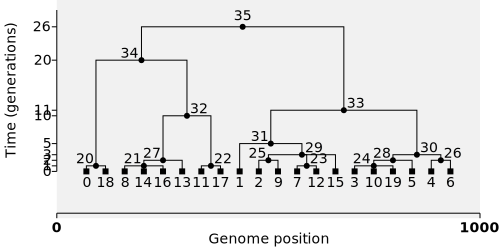

In [7]:
from IPython.display import SVG
ts = simulate_WrightFisher(Ne=10, gens=50)
SVG(ts.draw_svg(size=(500, 250), y_axis=True))

## Getting a tree

Tskit excels in encoding multiple correlated trees along the genome, and there are various ways to extract these trees from a tree sequence object. Here the base pairs from 0..1000 all share the same ancestry, shown by the fact that there is only one tree. This tree can be extracted using `ts.first()`:

In [8]:
tree = ts.first()
print(f"First of {ts.num_trees} tree(s) in the tree sequence")
display(tree)

First of 1 tree(s) in the tree sequence


Like a tree sequence, a _tskit_ `tree` has lots of useful methods. Given a set of node IDs, the `mrca()` and `tmrca()` methods return the ID of the most recent common ancestor (MRCA) node and the time of that node ($T_{\mathrm{MRCA}}$) respectively. For instance, let's look at the MRCA of nodes 18 and 19:

Node 34, the most recent common ancestor of nodes 18 and 19 lived 20.0 generations ago


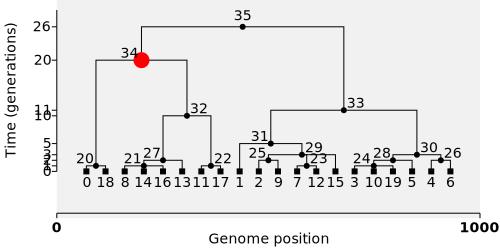

In [9]:
mrca_id = tree.mrca(17, 18)
mrca_time = tree.tmrca(17, 18)
print(
    f"Node {mrca_id}, the most recent common ancestor of nodes 18 and 19",
    f"lived {mrca_time} {ts.time_units} ago",
)

# Highlight it!
SVG(ts.draw_svg(size=(500, 250), y_axis=True, style=f".n{mrca_id}>.sym {{fill: red; r: 8px}}"))

Note, however, if we remove all the ancestry older than a given time (known as `decapitating` a tree sequence!), we might not have an MRCA between two nodes, in which case the `mrca` function will return a null value (_tskit_ uses -1 as the null ID). The resulting tree sequence will have [multiple roots](https://tskit.dev/tskit/docs/stable/data-model.html#roots), visualised as below:

The MRCA ID between node 18 and 19 in the decapitated tree sequence is -1


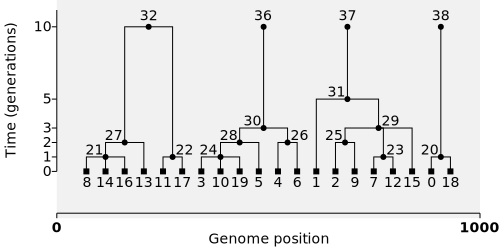

In [10]:
ts_recent = ts.decapitate(time=10.0)  # delete ancestry older than 10 generations ago
print(
    "The MRCA ID between node 18 and 19 in the decapitated tree sequence is",
    ts_recent.first().mrca(17, 18)
)
SVG(ts_recent.draw_svg(size=(500, 250), y_axis=True))

In [11]:
# The .tmrca() function will fail with a helpful message in this case
print(ts_recent.first().tmrca(17, 18))

ValueError: Nodes (17, 18) do not share a common ancestor in the tree

## Expected $T_\mathrm{MRCA}$

The expected time to the most recent common ancestor  for a randomly chosen pair of genomes is a classic result from coalescent theory. In a Wright-Fisher model, if the population is not tiny, it is well approximated by the negative exponential distribution with mean and variance equal to $2N_e$.


$$\frac{1}{2N_e}e^{-\frac{T_\mathrm{MRCA}}{2N_e}}$$


To see how well this theoretical approximation holds, one (inefficient) way to sample from the true MRCA distribution is to loop over the forward-time simulator repeatedly with different seeds.

Since this can take some time, we'll wrap the loop using the [tqdm library](https://tqdm.github.io/), so that we get a progress bar

In [12]:
from tqdm.auto import tqdm
Ne = 10
max_gens = 150  # need to run long enough to ensure there *is* an MRCA
fwdsim_tMRCAs = []
for seed in tqdm(np.arange(1, 300)):
  ts = simulate_WrightFisher(Ne=Ne, gens=max_gens, random_seed=seed)
  # Simply (arbitrarily) pick the MRCA between the first 2 nodes
  first_two_samples = ts.samples()[0:2]
  fwdsim_tMRCAs.append(ts.first().tmrca(*first_two_samples))

  0%|          | 0/299 [00:00<?, ?it/s]

<dl class="exercise"><dt>Exercise 1</dt>
<dd>use np.mean to print out the mean of the fwdsim_tMRCAs array</dd></dl>

In [ ]:
# Exercise 1: print the mean of fwdsim_tMRCAs

In [13]:
# Execute code block with <shift>+Return to display question; press on one of the buttons to answer
workbook.question("expected_tmrca")


KeyError: 'expected_tmrca'

We can plot out the entire distribution, not just the mean

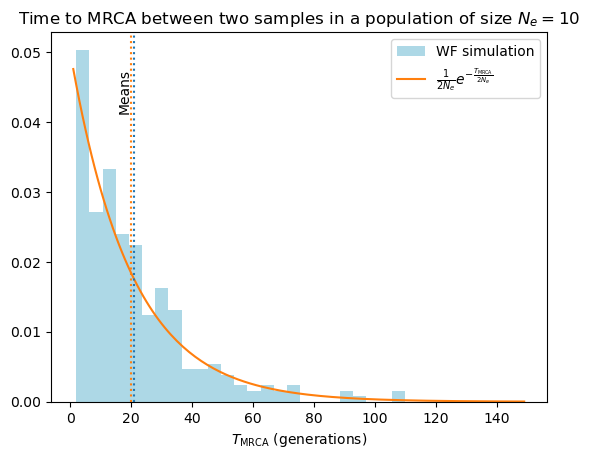

In [14]:
from matplotlib import pyplot as plt
plt.hist(fwdsim_tMRCAs, bins=25, density=True, label="WF simulation", color="lightblue")
x = np.arange(1, max_gens)
y = 1/(2 * Ne) * np.exp(-x/(2 * Ne))
formula = r"12Nee−TMRCA2Ne"
plt.plot(x, y, c="tab:orange", label=formula)
plt.axvline(np.mean(fwdsim_tMRCAs), ls=":", c="tab:blue")
plt.axvline(2 * Ne, ls=":", c="tab:orange")
plt.text(2 * Ne, y.max(), "Means", ha="right", va="top", rotation=90)
plt.xlabel(r"TMRCA (generations)")
plt.legend()
plt.title(f"Time to MRCA between two samples in a population of size $N_e={Ne}$");

The fit is pretty impressive, even though this is a very small population, when we would expect the approximation to be potentially poor. As we'll see later, results from coalescent theory are surprisingly robust to changes in the details of the underlying model.

## The incredible depth of human ancestry

It is often estimated that a historical "effective population size" ($N_e$) for humans is about 15 000 diploid individuals. If this is correct, what is the expected average TMRCA between (say) a region of your genome from you mother, compared the the same region you inherited from your father?

In [ ]:
# Execute code block with <shift>+Return to display question; press on one of the buttons to answer
workbook.question("Ne_calc")

### A popgen taster

To a casual observer, these times might seem too long ago. After all, this is much longer ago than the origin of modern humans. **** We can use perform a quick check, and illustrate the power of tree sequence storage. The estimated single-nucleotide mutation rate in humans is $\mu = ~1.29\times 10^{-8}$ per base pair per generation. The probability that any particular base pair will differ between a randomly chosen pair of sequences (the "genetic diversity", or $\pi$) will be the mutation rate times the number of generations separating the pair (i.e. twice the time to the most recent common ancestor, measured in generations).

$$ \pi = \mu \times 2 T_{\mathrm MRCA} $$

Or, given a genetic diversity, we can figure out a $T_{\mathrm MRCA}$ by dividing it by twice the mutation rate


In [17]:
# Download the compressed tree sequence for human chromosome 2, q arm (~180Mb - may take a number of seconds)
import os
import urllib.request
import tszip
if os.path.exists("")

else:
    url = "https://zenodo.org/record/5512994/files/hgdp_tgp_sgdp_high_cov_ancients_chr20_q.dated.trees.tsz"

    with workbook.download(url) as t:
        temporary_filename, _ = urllib.request.urlretrieve(url, reporthook=t.update_to)

estimated_tmrca = ts.trim().diversity()/ (2 * 1.29e-8)
print("The estimated time to {estimated_tmrca} generations ({estimated_tmrca * 30} years)")

hgdp_tgp_sgdp_high_cov_ancients_chr20_q.dated.trees.tsz: 37.4MB [00:06, 5.40MB/s]                            


## Advantages of backward simulation

Our forward-time Wright-Fisher simulator does not incoporate any natural selection: it is _neutral_. Neutral simulations, or indeed any simulations where the genomes are [exchangable](), can be implemented much more efficiently in reverse, or backward-time. In this case, we define an initial set of sample genomes and randomly choose parents for those genomes, then parents for the parents, and so on. This means we don't need to `simplify()` the genealogy, and it's far more efficient that forward-simulation because:

* we don't spend time simulating extinct lineages,

* we can efficiently simulate a small set of samples taken from a much larger population, and

* we can stop simulating as soon as the lineages from all the samples merge into a single MRCA

The major _downside_ is that backward simulation cannot deal with most forms of natural selection, or populations distributed in continuous space (but in later workbooks we will see how _tskit_ can be used to combine both backward and forward time simulation in a process known as [recapitation](https://tskit.dev/pyslim/docs/latest/tutorial.html#sec-tutorial-recapitation)).

### Msprime: a backward-time simulator

[_Msprime_]() is a widely-used and highly efficient backward-time simulator that outputs tree sequences. To match our forward-time model, we can use its [discrete-time-Wright-Fisher](https://tskit.dev/msprime/docs/stable/ancestry.html#using-the-dtwf-model) ("`dtwf`") capability:

In [ ]:
import msprime
Ne = 1_000   # Much faster to simulate large populations
ts = msprime.sim_ancestry(samples=10, population_size=Ne, model="dtwf", random_seed=123)
SVG(ts.draw_svg(size=(500, 250), y_axis=True))

#### Continuous-time models: a major speedup

However, the "`dtwf`" model is still fairly slow because it has to go generation by generation, backwards in time. If we assume that only one coalescence occurs in any generation, we can simply sample a time back to the next coalescent event from the appropriate distribution, without having to go generation-by-generation. This is the default model used by msprime, and it means that the size of the population no longer has an effect on the efficiency of the simulation. We can easily simulate a population of a billion individuals: all that happens is that the time scale will change.

(NB - however a constant size population of a billion coupled with generations times of a few years would create MRCAs older than the origin of life on earth, so clearly our assumptions are not biologically plausible here)

### Variation in coalescent tree depths and topologies

To demonstrate the efficiency of this approach, we'll sample 20 individuals from a population of a thousand, until all the samples have coalesced into a single root, which should take some thousands of generations. We'll do it 30 times, to get a feel for the wide variation in coalescence times. _Msprime_ will run this in a millisecond or two.

<div class="alert alert-block alert-info"><b>Note:</b> If the <code>num_replicates</code> parameter is given to <code>sim_ancestry()</code>, the function will return a (lazy) iterator over the returned tree sequences. To turn this into a fixed list of tree sequences, we apply Python's built-in <code>list()`</code> function.</div>

In [ ]:
# To get a feel of the variation in coalescent tree time & topologies

import msprime
from IPython.display import HTML  # we can draw multiple tree sequences using HTML

tree_seqs = list(
    msprime.sim_ancestry(
        20, population_size=1_000, sequence_length=1000, num_replicates=30, random_seed=123,
    )
)

root_times = [ts.max_time for ts in tree_seqs]
ticks = np.linspace(0, 10 ** (np.ceil(np.log10(max(root_times)))), num=6)
ticks = {t: f"{t/1_000:.0f}k" for t in ticks}

HTML("".join(
    ts.draw_svg(
        max_time=max(root_times),
        size=(200, 350),
        node_labels={},
        symbol_size=1,
        y_axis=True,
        y_ticks=ticks,
    )
    for ts in tree_seqs
))

Exercise: Because coalescent times are approximately exponentially distributed, it can be helpful to plot trees using a log timescale. Add `time_scale="log_time"` to the `draw_svg()` parameters below to see what this looks like. Then use `plt.hist()` to plot the distribution of root_times.

Q: The mean TMRCA for _two_ samples is 2Ne. What's the mean TMRCA for _n_ samples (i.e. the root time) as _n_ increases to larger numbers (e.g. here)

Answer: 4Ne: in fact, this is the limit as as n->inf, so you only double the time

## Information from additional samples

In a large population, as we increase the sample size from 2 genomes to thousands or millions, the additional common ancestors added to the genealogy will tend to be at younger and younger times. Another way to put this is that small numbers of genomes tend to contain information on deep history; increasing the sample size will tend to fill out information about more recent events.

We can see this by plotting the time of the additional node (if any) that is added to the tree as we increase the number of samples.

We'll compare the forward simulation to the reverse one...